In [ ]:
!pip install gym
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **0. 라이브러리 로드**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import random
import matplotlib.pyplot as plt
import numpy as np
import gym
import gym.spaces as sp

from tqdm import trange
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam
from collections import deque

### **1. Lunar lander 환경**

In [ ]:
train_env = gym.make('LunarLander-v2')
test_env = gym.make('LunarLander-v2')

print('State shape: ', train_env.observation_space.shape)
print('Number of actions: ', train_env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [ ]:
SEED = 1234

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);


### **2. PPO**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        x = self.net(x)
        return x


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred


In [ ]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)


In [ ]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
LEARNING_RATE = 0.0005

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [ ]:
def train(env, policy, optimizer, discount_factor, ppo_steps, ppo_clip):
        
    policy.train()
        
    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        #append state here, not after we get the next state from env.step()
        states.append(state)
        
        action_pred, value_pred = policy(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        
        episode_reward += reward
    
    states = torch.cat(states)
    actions = torch.cat(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip)

    return policy_loss, value_loss, episode_reward

In [ ]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns


In [ ]:
def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [ ]:
def update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip):
    
    total_policy_loss = 0 
    total_value_loss = 0
    
    states = states.detach()
    actions = actions.detach()
    log_prob_actions = log_prob_actions.detach()
    advantages = advantages.detach()
    returns = returns.detach()
    
    for _ in range(ppo_steps):
                
        #get new log prob of actions for all input states
        action_pred, value_pred = policy(states)
        value_pred = value_pred.squeeze(-1)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        
        #new log prob using old actions
        new_log_prob_actions = dist.log_prob(actions)
        
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
                
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).mean()
        
        value_loss = F.smooth_l1_loss(returns, value_pred).mean()
    
        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
    
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [ ]:
def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_pred, _ = policy(state)
            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
      
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward


In [ ]:
MAX_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10
PPO_STEPS = 5
PPO_CLIP = 0.2

ppo_train_rewards = []
ppo_test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, ppo_train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    ppo_test_reward = evaluate(test_env, policy)
    
    ppo_train_rewards.append(ppo_train_reward)
    ppo_test_rewards.append(ppo_test_reward)
    
    ppo_mean_train_rewards = np.mean(ppo_train_rewards[-N_TRIALS:])
    ppo_mean_test_rewards = np.mean(ppo_test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
        
        print(f'| Episode: {episode:3} | Mean Train Rewards: {ppo_mean_train_rewards:7.1f} | Mean Test Rewards: {ppo_mean_test_rewards:7.1f} |')

| Episode:  10 | Mean Train Rewards:  -190.1 | Mean Test Rewards:  -234.6 |
| Episode:  20 | Mean Train Rewards:  -151.3 | Mean Test Rewards:  -321.5 |
| Episode:  30 | Mean Train Rewards:  -130.0 | Mean Test Rewards:  -517.4 |
| Episode:  40 | Mean Train Rewards:  -164.4 | Mean Test Rewards:  -906.4 |
| Episode:  50 | Mean Train Rewards:  -301.2 | Mean Test Rewards:  -964.5 |
| Episode:  60 | Mean Train Rewards:  -397.9 | Mean Test Rewards:  -874.2 |
| Episode:  70 | Mean Train Rewards:  -344.9 | Mean Test Rewards:  -782.1 |
| Episode:  80 | Mean Train Rewards:  -206.4 | Mean Test Rewards:  -802.7 |
| Episode:  90 | Mean Train Rewards:  -142.3 | Mean Test Rewards:  -998.5 |
| Episode: 100 | Mean Train Rewards:   -55.5 | Mean Test Rewards: -1031.8 |
| Episode: 110 | Mean Train Rewards:   -60.4 | Mean Test Rewards: -1383.8 |
| Episode: 120 | Mean Train Rewards:  -128.7 | Mean Test Rewards: -1525.7 |
| Episode: 130 | Mean Train Rewards:  -156.1 | Mean Test Rewards: -1075.9 |
| Episode: 1

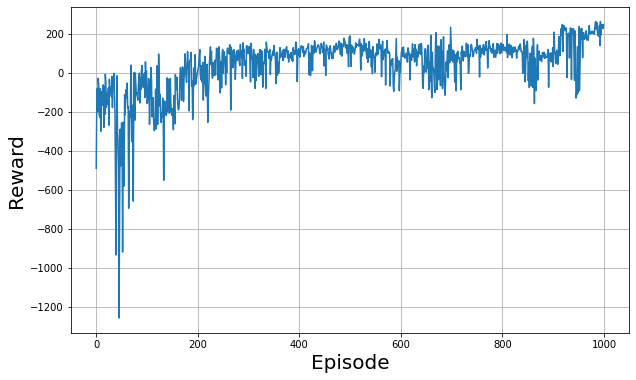

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(ppo_train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
#plt.ylim([25, 50])
plt.grid()


### **3. A2C**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        x = self.net(x)
        return x


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred


In [ ]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = test_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)


In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [ ]:
policy.apply(init_weights)


ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [ ]:
LEARNING_RATE = 0.0005

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)


In [ ]:
def train(env, policy, optimizer, discount_factor):
    
    policy.train()
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred = actor(state)
        value_pred = critic(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward
    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, episode_reward

In [ ]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        
        returns = (returns - returns.mean()) / returns.std()
        
    return returns


In [ ]:
def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages


In [ ]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer):
        
    advantages = advantages.detach()
    returns = returns.detach()
        
    policy_loss = - (advantages * log_prob_actions).sum()
    
    value_loss = F.smooth_l1_loss(returns, values).sum()
        
    optimizer.zero_grad()
    
    policy_loss.backward()
    value_loss.backward()
    
    optimizer.step()
    
    return policy_loss.item(), value_loss.item()


In [ ]:
def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward


In [ ]:
MAX_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')

| Episode:  10 | Mean Train Rewards:  -117.5 | Mean Test Rewards:   -72.6 |
| Episode:  20 | Mean Train Rewards:  -125.1 | Mean Test Rewards:  -109.1 |
| Episode:  30 | Mean Train Rewards:  -124.5 | Mean Test Rewards:  -104.4 |
| Episode:  40 | Mean Train Rewards:  -141.2 | Mean Test Rewards:  -160.4 |
| Episode:  50 | Mean Train Rewards:  -142.4 | Mean Test Rewards:  -199.4 |
| Episode:  60 | Mean Train Rewards:  -147.1 | Mean Test Rewards:  -214.3 |
| Episode:  70 | Mean Train Rewards:  -133.3 | Mean Test Rewards:  -275.6 |
| Episode:  80 | Mean Train Rewards:  -143.2 | Mean Test Rewards:  -490.8 |
| Episode:  90 | Mean Train Rewards:  -148.8 | Mean Test Rewards:  -798.5 |
| Episode: 100 | Mean Train Rewards:  -183.4 | Mean Test Rewards:  -916.5 |
| Episode: 110 | Mean Train Rewards:  -177.2 | Mean Test Rewards:  -939.1 |
| Episode: 120 | Mean Train Rewards:  -184.6 | Mean Test Rewards: -1068.1 |
| Episode: 130 | Mean Train Rewards:  -168.5 | Mean Test Rewards: -1153.5 |
| Episode: 1

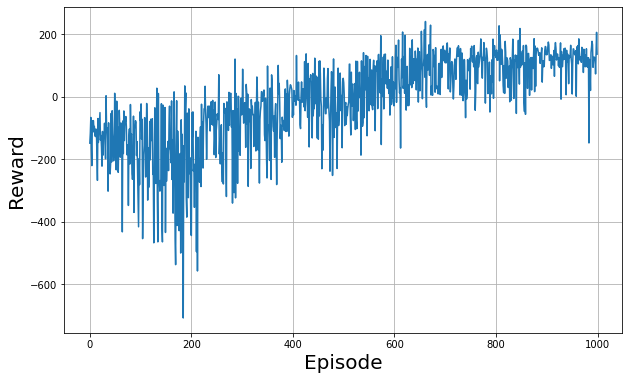

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.grid()


### **4. DQN**

In [ ]:
#Policy network
class QNet(nn.Module):
    # Policy Network
    def __init__(self, n_states, n_actions, n_hidden=64):
        super(QNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(n_states, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_actions)
            )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class DQN():
    def __init__(self, n_states, n_actions, batch_size=64, lr=1e-4, gamma=0.99, mem_size=int(1e5), learn_step=5, tau=1e-3):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau

        # model
        self.net_eval = QNet(n_states, n_actions)
        self.net_target = QNet(n_states, n_actions)
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # memory
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)
        self.counter = 0    # update cycle counter

    def getAction(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0)

        self.net_eval.eval()
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()

        # epsilon-greedy
        if random.random() < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            action = np.argmax(action_values.cpu().data.numpy())

        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        y_j = rewards + self.gamma * q_target * (1 - dones)          # target, if terminal then y_j = rewards
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.softUpdate()

    def softUpdate(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau*eval_param.data + (1.0-self.tau)*target_param.data)

In [ ]:
class ReplayBuffer():
    def __init__(self, n_actions, memory_size, batch_size):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = deque(maxlen = memory_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

In [ ]:
def train(env, agent, n_episodes=1000, max_steps=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, target=200, chkpt=False):
    score_hist = []
    epsilon = eps_start

    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt} [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    # bar_format = '{l_bar}{bar:10}{r_bar}'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)
    for idx_epi in pbar:
        state = env.reset()
        score = 0
        for idx_step in range(max_steps):
            action = agent.getAction(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.save2memory(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break

        score_hist.append(score)
        score_avg = np.mean(score_hist[-100:])
        epsilon = max(eps_end, epsilon*eps_decay)

        pbar.set_postfix_str(f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}")
        pbar.update(0)

        # Early stop
        if len(score_hist) >= 100:
            if score_avg >= target:
                break

    if (idx_epi+1) < n_episodes:
        print("\nTarget Reached!")
    else:
        print("\nDone!")
        
    if chkpt:
        torch.save(agent.net_eval.state_dict(), 'checkpoint.pth')

    return score_hist

In [ ]:
def plotScore(scores):
    plt.figure(figsize=(10,6))
    plt.plot(scores, label='Train Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Reward', fontsize=20)
    plt.grid()

In [ ]:
BATCH_SIZE = 128
LR = 1e-3
EPISODES = 1000
TARGET_SCORE = 200.     
GAMMA = 0.99            # discount factor
MEMORY_SIZE = 10000     # max memory buffer size
LEARN_STEP = 5          # how often to learn
TAU = 1e-3              # for soft update of target parameters
SAVE_CHKPT = False      # save trained network .pth file

In [ ]:
num_states = train_env.observation_space.shape[0]
num_actions = train_env.action_space.n

agent = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    lr = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
    )

score_hist = train(train_env, agent, n_episodes=EPISODES, target=TARGET_SCORE, chkpt=SAVE_CHKPT)
#plotScore(score_hist)

 99%|#########8|  986/1000 [  09:50<  00:08,  1.67ep/s, Score:  226.67, 100 score avg:  201.15]


Target Reached!


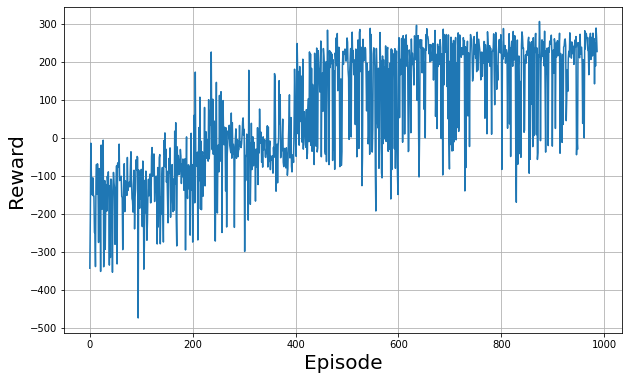

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(score_hist, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.grid()

### **5. DDQN**

In [ ]:
class Agent:
    def __init__(self, env, optimizer, batch_size):
        # general info
        self.state_size = env.observation_space.shape[0] # number of factors in the state; e.g: velocity, position, etc
        self.action_size = env.action_space.n
        self.optimizer = optimizer
        self.batch_size = batch_size
        
        # allow large replay exp space
        self.replay_exp = deque(maxlen=1000000)
        
        self.gamma = 0.99
        self.epsilon = 1.0 # initialize with high exploration, which will decay later
        
        # Build Policy Network
        self.brain_policy = Sequential()
        self.brain_policy.add(Dense(128, input_dim = self.state_size, activation = "relu"))
        self.brain_policy.add(Dense(128 , activation = "relu"))
        self.brain_policy.add(Dense(self.action_size, activation = "linear"))
        self.brain_policy.compile(loss = "mse", optimizer = self.optimizer)
        
        
        # Build Target Network
        self.brain_target = Sequential()
        self.brain_target.add(Dense(128, input_dim = self.state_size, activation = "relu"))
        self.brain_target.add(Dense(128 , activation = "relu"))
        self.brain_target.add(Dense(self.action_size, activation = "linear"))
        self.brain_target.compile(loss = "mse", optimizer = self.optimizer)
        
        
        self.update_brain_target()
    
    # add new experience to the replay exp
    def memorize_exp(self, state, action, reward, next_state, done):
        self.replay_exp.append((state, action, reward, next_state, done))
    
    def update_brain_target(self):
        return self.brain_target.set_weights(self.brain_policy.get_weights())
    
    def choose_action(self, state):
        if np.random.uniform(0.0, 1.0) < self.epsilon: # exploration
            action = np.random.choice(self.action_size)
        else:
            state = np.reshape(state, [1, state_size])
            qhat = self.brain_policy.predict(state) # output Q(s,a) for all a of current state
            action = np.argmax(qhat[0]) # because the output is m * n, so we need to consider the dimension [0]
            
        return action
     
    # update params in NN
    def learn(self):
        
        # take a mini-batch from replay experience
        cur_batch_size = min(len(self.replay_exp), self.batch_size)
        mini_batch = random.sample(self.replay_exp, cur_batch_size)
        
        # batch data
        sample_states = np.ndarray(shape = (cur_batch_size, self.state_size)) # replace 128 with cur_batch_size
        sample_actions = np.ndarray(shape = (cur_batch_size, 1))
        sample_rewards = np.ndarray(shape = (cur_batch_size, 1))
        sample_next_states = np.ndarray(shape = (cur_batch_size, self.state_size))
        sample_dones = np.ndarray(shape = (cur_batch_size, 1))

        temp=0
        for exp in mini_batch:
            sample_states[temp] = exp[0]
            sample_actions[temp] = exp[1]
            sample_rewards[temp] = exp[2]
            sample_next_states[temp] = exp[3]
            sample_dones[temp] = exp[4]
            temp += 1
        
        sample_qhat_next = self.brain_target.predict(sample_next_states)
        
        # set all Q values terminal states to 0
        sample_qhat_next = sample_qhat_next * (np.ones(shape = sample_dones.shape) - sample_dones)
        # choose max action for each state
        sample_qhat_next = np.max(sample_qhat_next, axis=1)
        
        sample_qhat = self.brain_policy.predict(sample_states)
        
        for i in range(cur_batch_size):
            a = sample_actions[i,0]
            sample_qhat[i,int(a)] = sample_rewards[i] + self.gamma * sample_qhat_next[i]
            
        q_target = sample_qhat
            
        self.brain_policy.fit(sample_states, q_target, epochs = 1, verbose = 0)

In [ ]:
optimizer = Adam(learning_rate = 0.0001)

agent = Agent(train_env, optimizer, batch_size = 64)
state_size = train_env.observation_space.shape[0]

timestep=0
rewards = []
aver_reward = []
aver = deque(maxlen=100)


for episode in range(1000):
    state = train_env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info = train_env.step(action)
        
        total_reward += reward
        
        agent.memorize_exp(state, action, reward, next_state, done)
        agent.learn()
        
        state = next_state
        timestep += 1
        
    aver.append(total_reward)     
    aver_reward.append(np.mean(aver))
    
    rewards.append(total_reward)
        
    # update model_target after each episode
    agent.update_brain_target()

    agent.epsilon = max(0.1, 0.995 * agent.epsilon) # decaying exploration
    print("Episode ", episode, 'total_reward:', rewards, 'mean reward', aver_reward)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
2/2 [==============================] - 0s 9ms/step
Episode  134 total_reward: [-376.5535232934629, -174.5381589357886, -343.94481277496374, -57.428056775471475, -116.5788576505077, -128.0866432302669, -209.3294269764953, -104.13123166906902, -65.70332583169781, -324.20744798467524, -97.02258948214693, -94.15048335916843, -220.74744175336787, -311.6658063173557, -171.09114558892387, -221.93031187969333, -349.9398829021577, -79.41218925422857, -167.42467773309403, -234.01077574129076, -100.33940247977822, -111.1623098235869, -334.59893224615683, -81.34695060888343, -144.835858277124, -85.75963995544605, -57.08133080505723, -410.2829912849653, -88.78916947798967, -129.74338191883982, -119.39296581668133, -162.30779881253773, -208.21560438008873, -195.95381535415947, -159.09741023409052, -321.4974693675714, 23.506088805388572, -142.84098863456506, -304.22216345066136, -289.14201849457936, -47.28465769713426, -268.4923476130663, -215.05241329150076, -42.7

In [ ]:
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(aver_reward)